### Imports & Logging Setup

In [47]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [53]:
import pandas as pd
import os
import logging
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

def load_selected_miRNAs(file_paths, features_per_method=125):
    """
    Load top N features from each method
    """
    feature_sets = {}
    
    for key, path in file_paths.items():
        if key == "processed_data":
            continue

        if os.path.exists(path):
            df = pd.read_csv(path)
            
            if key == "fold_change" and "log2_fold_change" in df.columns:
                df['abs_fc'] = abs(df["log2_fold_change"])
                selected = df.nlargest(features_per_method, 'abs_fc')["Unnamed: 0"]
                feature_sets[key] = set(selected)
                
            elif key == "chi_squared" and "Score" in df.columns:
                selected = df.nlargest(features_per_method, "Score")["Feature"]
                feature_sets[key] = set(selected)
                
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                selected = df.nlargest(features_per_method, "Info_Gain_General")["Feature"]
                feature_sets[key] = set(selected)
                
            elif key == "lasso" and "Coefficient" in df.columns:
                df['abs_coef'] = df["Coefficient"].abs()
                selected = df.nlargest(features_per_method, 'abs_coef')["Feature"]
                feature_sets[key] = set(selected)
            
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Combine features from all methods
    all_features = set()
    for features in feature_sets.values():
        all_features.update(features)
    
    # Convert to sorted list
    selected_features = sorted(list(all_features))
    
    # Log feature counts
    print("\nFeatures selected by method:")
    for method, features in feature_sets.items():
        print(f"{method}: {len(features)} features")
    print(f"\nTotal unique features after combining: {len(selected_features)}")
    
    # Print first few selected features
    print("\nFirst 10 selected features:")
    for i, feature in enumerate(selected_features[:10], 1):
        print(f"{i}. {feature}")
    
    return selected_features

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select features using fixed count approach
selected_features = load_selected_miRNAs(file_paths)

# Clean miRNA list
cleaned_miRNAs = [miRNA for miRNA in selected_features if miRNA.startswith("hsa-mir-")]

# Print final count
print(f"\nFinal count of selected miRNAs: {len(cleaned_miRNAs)}")

# Save selected features
output_df = pd.DataFrame(cleaned_miRNAs, columns=["Selected_miRNAs"])
output_df.to_csv("../results/selected_miRNAs.csv", index=False)

print("\nFeature selection complete. Selected features saved.")


Features selected by method:
fold_change: 125 features
chi_squared: 125 features
information_gain: 125 features
lasso: 125 features

Total unique features after combining: 429

First 10 selected features:
1. hsa-let-7a-2
2. hsa-mir-10a
3. hsa-mir-1181
4. hsa-mir-1184-1
5. hsa-mir-1184-3
6. hsa-mir-1193
7. hsa-mir-1197
8. hsa-mir-1236
9. hsa-mir-1237
10. hsa-mir-1238

Final count of selected miRNAs: 426

Feature selection complete. Selected features saved.


### Process Features & Labels for Multi-Output Classification

In [54]:
# Process Features & Labels for Multi-Output Classification
def process_features_and_labels(processed_data, selected_features, debug=True):
    """
    Process features and labels for multi-output classification.
    Ensures all 497 features are maintained through the pipeline.
    """
    # Create working copy of data
    processed_data = processed_data.copy()
    processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)
    
    if debug:
        print("\n=== Pre-Processing Checks ===")
        print(f"Initial features selected: {len(selected_features)}")
        print(f"Data shape before processing: {processed_data.shape}")
        
        # Verify feature presence
        present_features = [f for f in selected_features if f in processed_data.columns]
        print(f"Features found in dataset: {len(present_features)}")
        if len(present_features) != len(selected_features):
            print("\nWarning: Some features not found in dataset!")
            missing = set(selected_features) - set(processed_data.columns)
            print(f"Missing features (first 5): {list(missing)[:5]}")

        print("\nFeature ranges before standardization (first 5 features):")
        for feature in selected_features[:5]:
            if feature in processed_data.columns:
                data = processed_data[feature]
                print(f"{feature}:")
                print(f"  Min: {data.min():.3f}")
                print(f"  Max: {data.max():.3f}")
                print(f"  Mean: {data.mean():.3f}")
                print(f"  Std: {data.std():.3f}")

    # Ensure we're using all available selected features
    available_features = [f for f in selected_features if f in processed_data.columns]
    if len(available_features) != len(selected_features):
        logging.warning(f"Using {len(available_features)} out of {len(selected_features)} selected features")

    # Extract features and convert to numeric
    X = processed_data[available_features].apply(pd.to_numeric, errors='coerce')

    if debug:
        print("\n=== Numeric Conversion Check ===")
        print("Features shape after extraction:", X.shape)
        print("Any non-numeric values:", X.isna().any().any())

    # Extract labels
    y = processed_data[["diagnosis", "stage", "subtype"]]

    # Handle missing values
    if X.isnull().values.any() or y.isnull().values.any():
        if debug:
            print("\n=== Missing Value Analysis ===")
            print("Features with missing values:")
            missing_counts = X.isnull().sum()
            print(missing_counts[missing_counts > 0])
            print("\nLabels with missing values:")
            print(y.isnull().sum())

        valid_indices = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    if debug:
        print("\n=== Post-Standardization Check ===")
        print("Scaled data statistics:")
        print(X.describe().round(3))
        
        means = X.mean()
        stds = X.std()
        print("\nStandardization verification:")
        print(f"Mean range: [{means.min():.3f}, {means.max():.3f}] (should be close to 0)")
        print(f"Std range: [{stds.min():.3f}, {stds.max():.3f}] (should be close to 1)")

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y["diagnosis"]
    )

    if debug:
        print("\n=== Split Results ===")
        print(f"Training set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")
        print("\nClass distribution:")
        print("Training set:")
        print(y_train.groupby(['stage', 'subtype']).size())
        print("\nTest set:")
        print(y_test.groupby(['stage', 'subtype']).size())

    return X_train, X_test, y_train, y_test

# Execute the processing
if __name__ == "__main__":
    # Process features and labels
    X_train, X_test, y_train, y_test = process_features_and_labels(
        processed_data, 
        selected_features,
        debug=True  # This ensures we see all the debug output
    )

    # Debugging: Check the prepared data
    print("\nExpression values sample:")
    print(X_train.head())

    print("\nFeature statistics:")
    print(X_train.describe())

    print("\nClass proportions in train set:")
    print(y_train["diagnosis"].value_counts(normalize=True))


=== Pre-Processing Checks ===
Initial features selected: 429
Data shape before processing: (1091, 1884)
Features found in dataset: 429

Feature ranges before standardization (first 5 features):
hsa-let-7a-2:
  Min: 1637.866
  Max: 38820.341
  Mean: 10011.778
  Std: 6028.659
hsa-mir-10a:
  Min: 2184.189
  Max: 313368.293
  Mean: 26700.175
  Std: 25479.753
hsa-mir-1181:
  Min: 0.000
  Max: 12.866
  Mean: 0.301
  Std: 0.533
hsa-mir-1184-1:
  Min: 0.000
  Max: 0.162
  Mean: 0.000
  Std: 0.005
hsa-mir-1184-3:
  Min: 0.000
  Max: 0.143
  Mean: 0.000
  Std: 0.004

=== Numeric Conversion Check ===
Features shape after extraction: (1091, 429)
Any non-numeric values: False

=== Post-Standardization Check ===
Scaled data statistics:
       hsa-let-7a-2  hsa-mir-10a  hsa-mir-1181  hsa-mir-1184-1  \
count      1091.000     1091.000      1091.000        1091.000   
mean         -0.000       -0.000        -0.000           0.000   
std           1.000        1.000         1.000           1.000   
min

### Train-Test Split & Feature Scaling

In [ ]:
def prepare_train_test_splits(processed_data, selected_features, debug=True):
    """
    Prepare train-test splits while handling rare cases and scaling features
    """
    # Create working copy
    filtered_data = processed_data.copy()
    
    # Remove rare cases
    rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove
    filtered_data = filtered_data[~filtered_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()
    
    # Remove subtype 4 (rare case)
    filtered_data = filtered_data[filtered_data["subtype"] != 4]
    
    # Update diagnosis column
    filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)
    
    if debug:
        print("\nData shape after filtering rare cases:", filtered_data.shape)
        print("\nClass distribution after filtering:")
        print(filtered_data.groupby(['stage', 'subtype']).size())
    
    # Extract features
    expression_values = filtered_data[selected_features]
    
    # Split for Diagnosis Model
    X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
        expression_values, 
        filtered_data["diagnosis"], 
        test_size=0.2, 
        random_state=42, 
        stratify=filtered_data["diagnosis"]
    )
    
    # Split for Stage & Subtype (cancer patients only)
    cancer_only = filtered_data["diagnosis"] == 1
    X_cancer = expression_values[cancer_only]
    y_cancer = filtered_data[cancer_only][["stage", "subtype"]]
    
    if debug:
        print("\nCancer patients class distribution before splitting:")
        print(y_cancer.groupby(['stage', 'subtype']).size())
    
    # Check for minimum class size
    min_class_size = y_cancer.groupby(['stage', 'subtype']).size().min()
    stratify_option = y_cancer if min_class_size >= 2 else None
    
    if debug and stratify_option is None:
        print("\nWarning: Some classes have too few samples. Using random split.")
    
    # Split cancer data
    X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
        X_cancer, 
        y_cancer, 
        test_size=0.2, 
        random_state=42, 
        stratify=stratify_option
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_diagnosis_scaled = scaler.fit_transform(X_train_diagnosis)
    X_test_diagnosis_scaled = scaler.transform(X_test_diagnosis)
    
    scaler_cancer = StandardScaler()
    X_train_cancer_scaled = scaler_cancer.fit_transform(X_train_cancer)
    X_test_cancer_scaled = scaler_cancer.transform(X_test_cancer)
    
    if debug:
        print("\nFinal shapes:")
        print(f"Diagnosis - Train: {X_train_diagnosis_scaled.shape}, Test: {X_test_diagnosis_scaled.shape}")
        print(f"Cancer   - Train: {X_train_cancer_scaled.shape}, Test: {X_test_cancer_scaled.shape}")
        
        print("\nClass distributions:")
        print("\nDiagnosis Train:")
        print(y_train_diagnosis.value_counts(normalize=True))
        print("\nDiagnosis Test:")
        print(y_test_diagnosis.value_counts(normalize=True))
        
        print("\nCancer Train:")
        print(y_train_cancer.groupby(['stage', 'subtype']).size())
        print("\nCancer Test:")
        print(y_test_cancer.groupby(['stage', 'subtype']).size())
    
    return (
        X_train_diagnosis_scaled, X_test_diagnosis_scaled, y_train_diagnosis, y_test_diagnosis,
        X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer
    )

# Execute the splitting and scaling
splits = prepare_train_test_splits(
    processed_data=processed_data,
    selected_features=cleaned_miRNAs,  # Using our 429 selected features
    debug=True
)

# Unpack the results
(X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis,
 X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer) = splits


Data shape after filtering rare cases: (1083, 1884)

Class distribution after filtering:
stage  subtype
0      0           11
1      1          312
       2          254
2      1          134
       2          174
3      1           90
       2           84
4      1           24
dtype: int64

Cancer patients class distribution before splitting:
stage  subtype
1      1          312
       2          254
2      1          134
       2          174
3      1           90
       2           84
4      1           24
dtype: int64

Final shapes:
Diagnosis - Train: (866, 426), Test: (217, 426)
Cancer   - Train: (857, 426), Test: (215, 426)

Class distributions:

Diagnosis Train:
diagnosis
1    0.989607
0    0.010393
Name: proportion, dtype: float64

Diagnosis Test:
diagnosis
1    0.990783
0    0.009217
Name: proportion, dtype: float64

Cancer Train:
stage  subtype
1      1          250
       2          203
2      1          107
       2          139
3      1           72
       2           67

### Train Multi-Output SVM Model

In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import joblib
import json
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Define Stratified Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to Train SVM with Hyperparameter Tuning
def train_svm(X_train, y_train, X_test, y_test, task_name):
    print(f"\nTraining {task_name} SVM...")
    
    # Define SVM with balanced class weights and probability enabled
    svm = SVC(class_weight="balanced", random_state=42, probability=True)
    
    # Grid search for hyperparameter tuning
    grid = GridSearchCV(svm, param_grid, cv=stratified_kfold, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Get best model and make predictions
    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test)

    # Log best hyperparameters
    logging.info(f"Best SVM Hyperparameters ({task_name}): {grid.best_params_}")
    
    # Print classification report
    print(f"\nClassification Report for {task_name}:\n", classification_report(y_test, y_pred))

    return best_svm, y_pred

# Train SVM for Diagnosis (Binary Classification)
best_svm_diagnosis, y_pred_diagnosis = train_svm(
    X_train_diagnosis, y_train_diagnosis, X_test_diagnosis, y_test_diagnosis, "Diagnosis"
)

# Train SVM for Stage (Multiclass Classification)
best_svm_stage, y_pred_stage = train_svm(
    X_train_cancer, y_train_cancer["stage"], X_test_cancer, y_test_cancer["stage"], "Stage"
)

# Train SVM for Subtype (Multiclass Classification)
best_svm_subtype, y_pred_subtype = train_svm(
    X_train_cancer, y_train_cancer["subtype"], X_test_cancer, y_test_cancer["subtype"], "Subtype"
)

# Save trained models
joblib.dump(best_svm_diagnosis, "../results/best_svm_diagnosis.pkl")
joblib.dump(best_svm_stage, "../results/best_svm_stage.pkl")
joblib.dump(best_svm_subtype, "../results/best_svm_subtype.pkl")

# Save classification reports for future analysis
reports = {
    "diagnosis": classification_report(y_test_diagnosis, y_pred_diagnosis, output_dict=True),
    "stage": classification_report(y_test_cancer["stage"], y_pred_stage, output_dict=True),
    "subtype": classification_report(y_test_cancer["subtype"], y_pred_subtype, output_dict=True),
}

with open("../results/svm_classification_reports.json", "w") as f:
    json.dump(reports, f, indent=4)

logging.info("SVM models trained and saved successfully.")


Training Diagnosis SVM...


2025-02-08 20:34:01,406 - INFO - Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}



Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...


2025-02-08 20:34:07,188 - INFO - Best SVM Hyperparameters (Stage): {'C': 1, 'gamma': 10, 'kernel': 'rbf'}



Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg       0.37      0.52      0.37       215


Training Subtype SVM...


2025-02-08 20:34:10,780 - INFO - Best SVM Hyperparameters (Subtype): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
2025-02-08 20:34:10,814 - INFO - SVM models trained and saved successfully.



Classification Report for Subtype:
               precision    recall  f1-score   support

           1       0.57      0.56      0.57       112
           2       0.53      0.53      0.53       103

    accuracy                           0.55       215
   macro avg       0.55      0.55      0.55       215
weighted avg       0.55      0.55      0.55       215



### Evaluate Multi-Output Model


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 0.9908

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Confusion Matrix:
 [[  0   2]
 [  0 215]]

Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


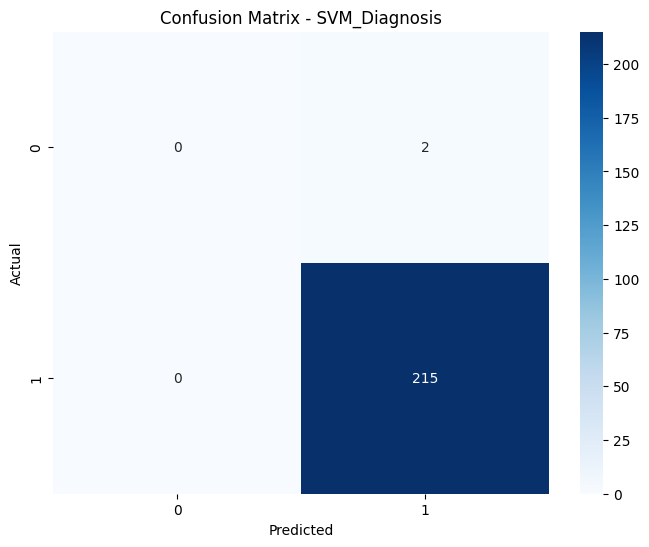

2025-02-08 20:35:17,587 - INFO - 
Model Evaluation Completed for SVM_Diagnosis!
2025-02-08 20:35:17,588 - INFO - Accuracy: 0.9908
2025-02-08 20:35:17,588 - INFO - Confusion Matrix: [[0, 2], [0, 215]]



-------------------- SVM_Stage Results --------------------

Accuracy: 0.5209

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg       0.37      0.52      0.37       215


Confusion Matrix:
 [[111   2   0   0]
 [ 61   1   0   0]
 [ 35   0   0   0]
 [  5   0   0   0]]

Confusion matrix saved to ../results/svm/svm_stage_confusion_matrix.png


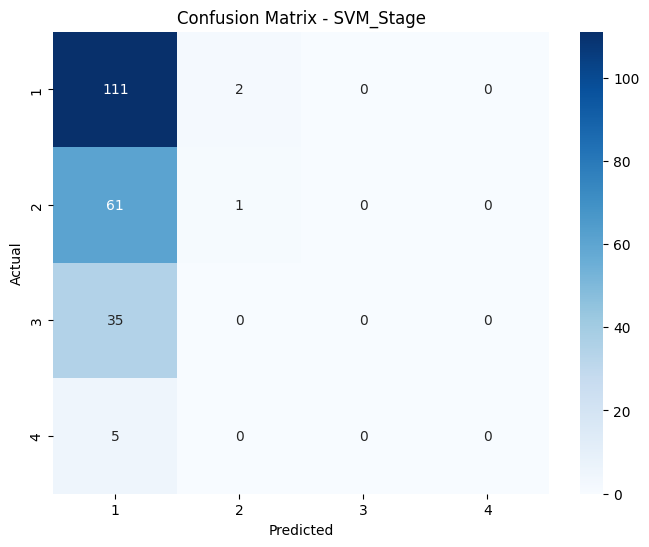

2025-02-08 20:35:17,840 - INFO - 
Model Evaluation Completed for SVM_Stage!
2025-02-08 20:35:17,841 - INFO - Accuracy: 0.5209
2025-02-08 20:35:17,841 - INFO - Confusion Matrix: [[111, 2, 0, 0], [61, 1, 0, 0], [35, 0, 0, 0], [5, 0, 0, 0]]



-------------------- SVM_Subtype Results --------------------

Accuracy: 0.5488

Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.56      0.57       112
           2       0.53      0.53      0.53       103

    accuracy                           0.55       215
   macro avg       0.55      0.55      0.55       215
weighted avg       0.55      0.55      0.55       215


Confusion Matrix:
 [[63 49]
 [48 55]]

Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


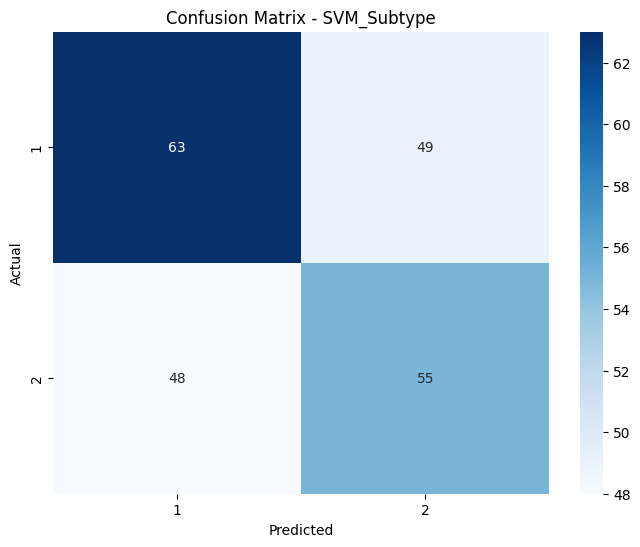

2025-02-08 20:35:18,060 - INFO - 
Model Evaluation Completed for SVM_Subtype!
2025-02-08 20:35:18,060 - INFO - Accuracy: 0.5488
2025-02-08 20:35:18,061 - INFO - Confusion Matrix: [[63, 49], [48, 55]]


In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

def evaluate_model(y_test, y_pred, model_name, save_dir="../results/svm/"):
    """
    Evaluate model performance with accuracy, classification reports, and confusion matrices.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the plot
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")

    plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Confusion Matrix: {cm.tolist()}")

    return {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

# Evaluate Diagnosis Model**
metrics_diagnosis = evaluate_model(y_test_diagnosis, y_pred_diagnosis, model_name="SVM_Diagnosis")

# Evaluate Stage Model**
metrics_stage = evaluate_model(y_test_cancer["stage"], y_pred_stage, model_name="SVM_Stage")

# Evaluate Subtype Model**
metrics_subtype = evaluate_model(y_test_cancer["subtype"], y_pred_subtype, model_name="SVM_Subtype")

### Visualize Performance Metrics


Classification Report for Precision, Recall, F1-score - Diagnosis Classification:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217

Metrics comparison saved to ../results/svm/plots/diagnosis_metrics_comparison.png


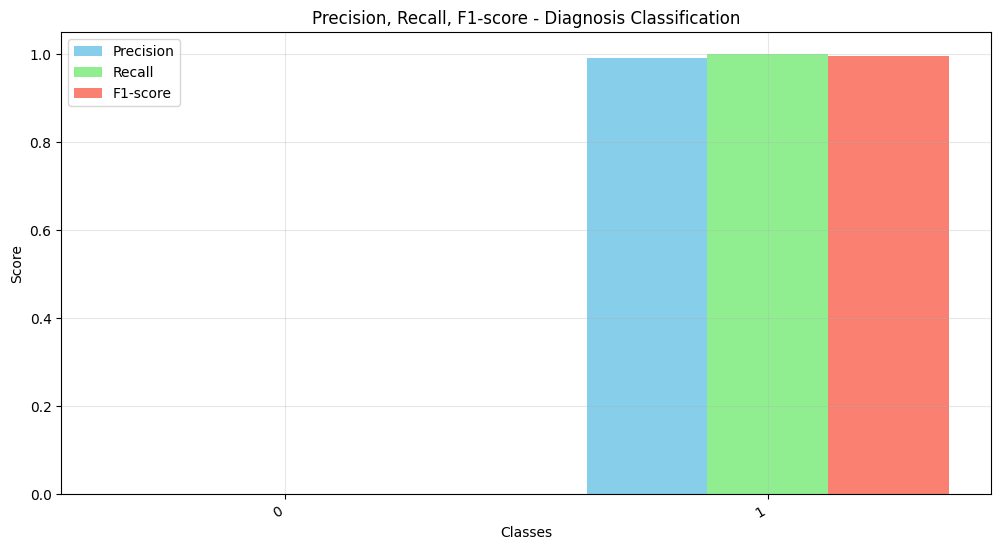


Classification Report for Precision, Recall, F1-score - Stage Classification:

              precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg       0.37      0.52      0.37       215

Metrics comparison saved to ../results/svm/plots/stage_metrics_comparison.png


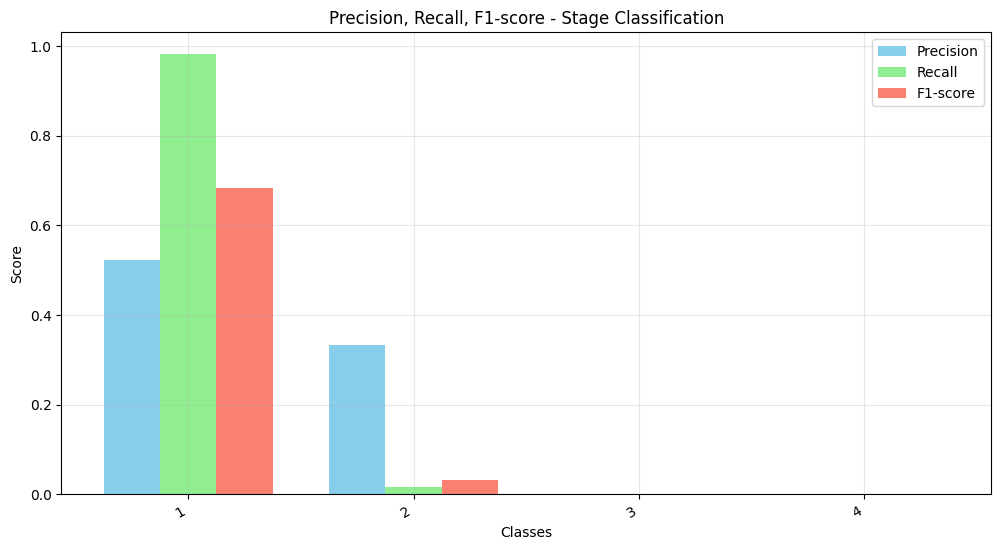


Classification Report for Precision, Recall, F1-score - Subtype Classification:

              precision    recall  f1-score   support

           1       0.57      0.56      0.57       112
           2       0.53      0.53      0.53       103

    accuracy                           0.55       215
   macro avg       0.55      0.55      0.55       215
weighted avg       0.55      0.55      0.55       215

Metrics comparison saved to ../results/svm/plots/subtype_metrics_comparison.png


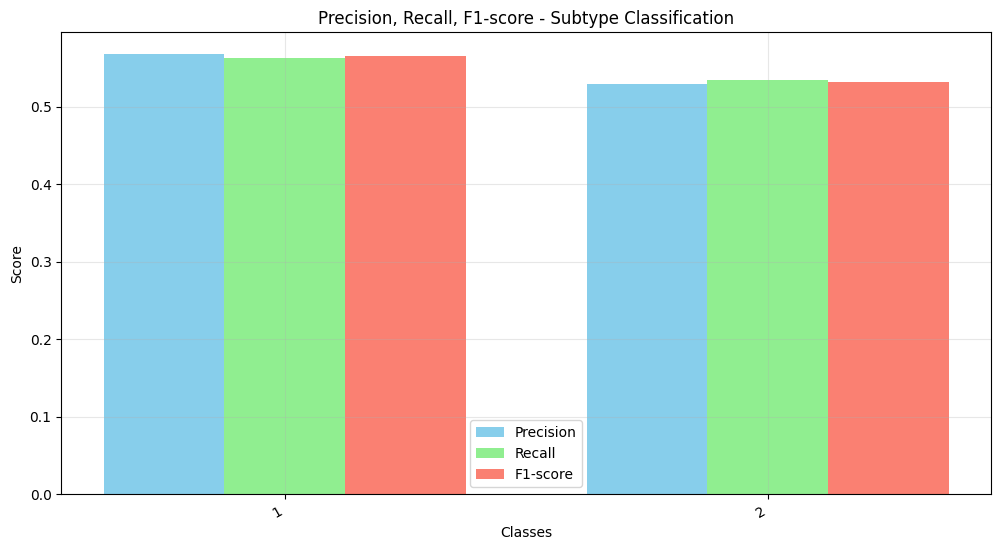

In [34]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define save directory
save_dir = "../results/svm/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class and prints the classification report."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)
    
    # Restored Print Output
    print(f"\nClassification Report for {title}:\n")
    print(classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels]))

    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# Diagnosis Visualization (Now with Print Output)
diagnosis_labels = sorted(y_test_diagnosis.unique())
plot_metrics_comparison(y_test_diagnosis, y_pred_diagnosis, diagnosis_labels, 
                        "Precision, Recall, F1-score - Diagnosis Classification", 
                        save_path=os.path.join(save_dir, "diagnosis_metrics_comparison.png"))

# Stage Visualization (Now with Print Output)
stage_labels = sorted(y_test_cancer["stage"].unique())
plot_metrics_comparison(y_test_cancer["stage"], y_pred_stage, stage_labels, 
                        "Precision, Recall, F1-score - Stage Classification", 
                        save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

# Subtype Visualization (Now with Print Output)
subtype_labels = sorted(y_test_cancer["subtype"].unique())
plot_metrics_comparison(y_test_cancer["subtype"], y_pred_subtype, subtype_labels, 
                        "Precision, Recall, F1-score - Subtype Classification", 
                        save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline

In [26]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels for Diagnosis**
predictions_diagnosis_path = os.path.join(output_dir, "svm_predictions_diagnosis.csv")
pd.DataFrame({"actual": y_test_diagnosis, "predicted": y_pred_diagnosis}).to_csv(predictions_diagnosis_path, index=False)
logging.info(f"Diagnosis predictions saved to {predictions_diagnosis_path}")

# Save Predictions & Actual Labels for Stage**
predictions_stage_path = os.path.join(output_dir, "svm_predictions_stage.csv")
pd.DataFrame({"actual": y_test_cancer["stage"], "predicted": y_pred_stage}).to_csv(predictions_stage_path, index=False)
logging.info(f"Stage predictions saved to {predictions_stage_path}")

# Save Predictions & Actual Labels for Subtype**
predictions_subtype_path = os.path.join(output_dir, "svm_predictions_subtype.csv")
pd.DataFrame({"actual": y_test_cancer["subtype"], "predicted": y_pred_subtype}).to_csv(predictions_subtype_path, index=False)
logging.info(f"Subtype predictions saved to {predictions_subtype_path}")

# Save Experiment Metadata**
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_,
    "stage_hyperparameters": grid_stage.best_params_,
    "subtype_hyperparameters": grid_subtype.best_params_,
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "train_set_size_diagnosis": X_train_diagnosis.shape[0],
    "train_set_size_stage": X_train_cancer.shape[0],
    "test_set_size_diagnosis": X_test_diagnosis.shape[0],
    "test_set_size_stage": X_test_cancer.shape[0],
}

metadata_path = os.path.join(output_dir, "svm_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# **5️ Save Trained Models**
model_diagnosis_path = os.path.join(output_dir, "svm_model_diagnosis.pkl")
joblib.dump(best_svm_diagnosis, model_diagnosis_path)
logging.info(f"Diagnosis model saved to {model_diagnosis_path}")

model_stage_path = os.path.join(output_dir, "svm_model_stage.pkl")
joblib.dump(best_svm_stage, model_stage_path)
logging.info(f"Stage model saved to {model_stage_path}")

model_subtype_path = os.path.join(output_dir, "svm_model_subtype.pkl")
joblib.dump(best_svm_subtype, model_subtype_path)
logging.info(f"Subtype model saved to {model_subtype_path}")

print("\n All results successfully saved. The SVM pipeline is complete!")

2025-02-08 19:52:31,661 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-02-08 19:52:31,663 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-02-08 19:52:31,665 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-02-08 19:52:31,667 - INFO - Metadata saved to ../results/svm/svm_metadata.json
2025-02-08 19:52:31,669 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.pkl
2025-02-08 19:52:31,672 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl
2025-02-08 19:52:31,675 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.pkl



 All results successfully saved. The SVM pipeline is complete!
